In [51]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import tqdm

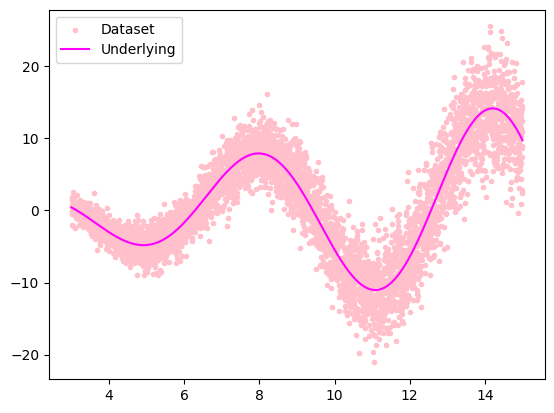

In [52]:
def f(x):
    return x * np.sin(x)

xMin = 3
xMax = 15
nSample = 5000

# input
x = np.linspace(xMin, xMax, nSample)
x_actual = np.linspace(xMin, xMax, nSample)
y_actual = f(x)

np.random.shuffle(x)

np.random.seed(17)
epsilon1 = np.random.normal(0.0, 0.3, nSample)
epsilon2 = np.random.normal(0.0, 0.3, nSample)

y = f(x) + epsilon1 + epsilon2 * x

plt.scatter(x, y, label = "Dataset", color = "pink", s = 9)
plt.plot(x_actual, y_actual, label = "Underlying", color = "magenta")
plt.legend()
plt.show()

X_train = x.reshape(-1, 1)
y_train = y.reshape(-1, 1)
X_test = np.arange(xMin, xMax+5, 0.01).reshape(-1, 1)

In [54]:
class GradientBoostedTreesEnsembleRegressor(tf.keras.Model):
    def __init__(self, n_trees=100, max_depth=3, n_estimators=100, sample_method='RANDOM'): 
        super(GradientBoostedTreesEnsembleRegressor, self).__init__()
        self.n_trees = n_trees
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.sample_method = sample_method
        self.estimators = []

    def build_estimator(self):
        model = tfdf.keras.GradientBoostedTreesModel(
            task=tfdf.keras.Task.REGRESSION,
            num_trees=self.n_trees,
            max_depth=np.random.randint(self.max_depth/2, self.max_depth+1),
            validation_ratio=0.1,
            sampling_method=self.sample_method,
            random_seed=self.seed # try to set this first. Maybe this is enough
        )
        return model
    
    # if not, the number of trees/depth different for each estimator

    def fit(self, X, y):
        num_data = X.shape[0]
        
        for seed in np.random.randint(0, 1000000, size=self.n_estimators):
            self.seed = int(seed) #passed to build_estimator
            
            # get the data index as a list
            indices = np.arange(num_data)
            indices = list(indices)
            
            # select a subset of indices for training
            train_estimator_size = int(len(indices)) 
            train_estimator_indices = np.random.choice(indices, size=train_estimator_size, replace=False)
            X_estimator_train = X[train_estimator_indices]
            y_estimator_train = y[train_estimator_indices]
            
            # building each estimator
            estimator = self.build_estimator()
            estimator.fit(X_estimator_train, y_estimator_train)
            
            self.estimators.append(estimator)

    def predict(self, X):
        predictions = []
        
        for estimator in self.estimators:
            estimator_predictions = estimator.predict(X)  # Get predictions from the current estimator
            predictions.append(estimator_predictions)
        
        # Stack all predictions along the last axis (-1)
        predictions_stacked = tf.stack(predictions, axis=-1)
        
        # Compute mean and variance across the stacked predictions
        mean_prediction = tf.reduce_mean(predictions_stacked, axis=-1)
        variance_prediction = tf.math.reduce_std(predictions_stacked, axis=-1)
        
        return mean_prediction, variance_prediction



In [43]:
class Cali(tf.keras.Model):
    def __init__(self, n_trees=100, max_depth=3, n_estimators=100, subportion = 0.8, sample_method='RANDOM'): 
        super(Cali, self).__init__()
        self.n_trees = n_trees
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.subportion = subportion
        self.sample_method = sample_method
        self.estimators = []

    def build_estimator(self):
        model = tfdf.keras.GradientBoostedTreesModel(
            task=tfdf.keras.Task.REGRESSION,
            num_trees=np.random.randint(self.n_trees/5, self.n_trees+1), # self.n_trees, #
            max_depth=self.max_depth, #np.random.randint(self.max_depth/2, self.max_depth+1), # self.max_depth, # 
            validation_ratio=0.1,
            subsample=self.subportion,
            sampling_method=self.sample_method,
            random_seed=self.seed # try to set this first. Maybe this is enough
        )
        return model
    
    # if not, the number of trees/depth different for each estimator

    def fit(self, X, y):
        
        for seed in np.random.randint(0, 1000000, size=self.n_estimators):
            self.seed = int(seed)
            indices = np.arange(len(X))
            indices = list(indices)
            subset_size = int(self.subportion * len(X))
            
            # Create a subset of the dataset using sampled indices
            subset_indices = np.random.choice(indices, size=subset_size, replace=False)
            
            # X_train = X.loc[subset_indices].reset_index(drop=True)
            # y_train = y.loc[subset_indices].reset_index(drop=True)

            X_tensor = X[subset_indices]
            y_tensor = y[subset_indices]
            # X_tensor = tf.constant(X_train.values, dtype=tf.float32)
            # y_tensor = tf.constant(y_train.values, dtype=tf.float32)
        
            
            # subset_dataset = (X_tensor, y_tensor)
            
            # building each estimator
            estimator = self.build_estimator()
            estimator.fit(X_tensor,y_tensor)
            self.estimators.append(estimator)
    
    #something's not right here
    def predict(self, X): # use all estimators
        predictions = []
        # sampled_estimators = np.random.choice(self.estimators, size=n_samples, replace=False)
        for estimator in self.estimators:
            estimator_predictions = []
            estimator_predictions.append(estimator.predict(X))
            estimator_predictions = tf.stack(estimator_predictions, axis=-1)
            predictions.append(tf.reduce_mean(estimator_predictions, axis=-1))
        predictions = tf.stack(predictions, axis=0)
        
        mean_prediction = tf.reduce_mean(predictions, axis=0)
        variance_prediction = tf.math.reduce_std(predictions, axis=0)
        return mean_prediction, variance_prediction


In [55]:
gbt_model = GradientBoostedTreesEnsembleRegressor(
    n_trees=50, 
    max_depth=5, 
    n_estimators=80, 
    # subportion=0.3, 
    sample_method='RANDOM'
)

In [45]:
cali_model = Cali(
    n_trees=50, 
    max_depth=5, 
    n_estimators=80, 
    subportion=0.8, 
    sample_method='RANDOM'
)

In [56]:
gbt_model.fit(X_train, y_train)

Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5wykdrkj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.145680. Found 5000 examples.
Training model...


[WARNING 24-05-16 11:16:46.9542 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:46.9542 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:46.9542 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.079389
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw9h3o8ed as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107411. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:47.1825 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5wykdrkj/model/ with prefix 3d512d2c752a419c
[INFO 24-05-16 11:16:47.1837 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-05-16 11:16:47.1837 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:47.2554 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:47.2554 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:47.2554 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.077690
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpttyt9hx7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.100968. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:47.4420 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw9h3o8ed/model/ with prefix c9a1307bd3b442ed
[INFO 24-05-16 11:16:47.4432 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:47.5085 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:47.5085 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:47.5085 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.103405
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi5ncifvo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107897. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:47.7153 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpttyt9hx7/model/ with prefix 8c15e6057d68416d
[INFO 24-05-16 11:16:47.7171 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:47.7927 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:47.7927 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:47.7927 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.078590
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzphyyl84 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.108482. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:47.9813 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi5ncifvo/model/ with prefix b0601c60c1994ad8
[INFO 24-05-16 11:16:47.9823 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:48.0445 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:48.0446 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:48.0446 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.077750
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdu6z2r10 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107680. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:48.2348 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzphyyl84/model/ with prefix 70ca89dc54754b3c
[INFO 24-05-16 11:16:48.2358 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:48.2990 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:48.2990 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:48.2990 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.034968
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppnlsk5dx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.115223. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:48.4444 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdu6z2r10/model/ with prefix 0e1928e758d04312
[INFO 24-05-16 11:16:48.4447 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:48.5083 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:48.5083 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:48.5083 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.077327
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprsz_l0ak as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105636. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:48.7024 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppnlsk5dx/model/ with prefix 7fcd8d1cf6094500
[INFO 24-05-16 11:16:48.7035 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:48.7713 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:48.7713 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:48.7713 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.039014
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvximrqvi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107419. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:48.9181 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprsz_l0ak/model/ with prefix 8e69ec91d7ff4281
[INFO 24-05-16 11:16:48.9185 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:48.9789 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:48.9789 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:48.9789 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.102778
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkijpkcj_ as temporary training directory
Reading training dataset...


[INFO 24-05-16 11:16:49.1919 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvximrqvi/model/ with prefix f3a4434f41c1401a
[INFO 24-05-16 11:16:49.1934 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:49.2651 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:49.2651 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:49.2651 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.206731. Found 5000 examples.
Training model...
Model trained in 0:00:00.057028
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb8gez15t as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107642. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:49.5307 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkijpkcj_/model/ with prefix 0f19f1c34459404d
[INFO 24-05-16 11:16:49.5312 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:49.5963 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:49.5963 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:49.5963 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.057756
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqk2lk7fi as temporary training directory
Reading training dataset...


[INFO 24-05-16 11:16:49.7659 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb8gez15t/model/ with prefix 7498de3d16e64c45
[INFO 24-05-16 11:16:49.7666 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:49.8542 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:49.8542 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:49.8542 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153204. Found 5000 examples.
Training model...
Model trained in 0:00:00.077654
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8_ssa7vi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106557. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:50.0868 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqk2lk7fi/model/ with prefix 500b26d5e75449f1
[INFO 24-05-16 11:16:50.0877 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:50.1489 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:50.1489 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:50.1489 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.059419
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0a1ydv0x as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107484. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:50.3210 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8_ssa7vi/model/ with prefix c4de4774c672420f
[INFO 24-05-16 11:16:50.3216 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:50.3831 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:50.3831 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:50.3831 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.078169
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3w2eunk9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.099397. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:50.5705 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0a1ydv0x/model/ with prefix 693cc57662604464
[INFO 24-05-16 11:16:50.5714 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:50.6413 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:50.6413 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:50.6413 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.103646
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbr03qbhb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.100814. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:50.8464 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3w2eunk9/model/ with prefix e6b2b23c9f0942ce
[INFO 24-05-16 11:16:50.8481 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:50.9086 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:50.9086 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:50.9087 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.055987
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_h0w5nwg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105628. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:51.0675 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbr03qbhb/model/ with prefix 6b04295258b04695
[INFO 24-05-16 11:16:51.0680 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:51.1277 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:51.1277 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:51.1277 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.039953
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp92trx9lo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.109770. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:51.2760 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_h0w5nwg/model/ with prefix 2798aa1c878c4b06
[INFO 24-05-16 11:16:51.2764 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:51.3377 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:51.3377 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:51.3377 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.056067
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq21d37jk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104680. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:51.5059 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp92trx9lo/model/ with prefix d846da9367bc427b
[INFO 24-05-16 11:16:51.5064 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:51.5767 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:51.5767 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:51.5767 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.106042
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpteohinjb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.102230. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:51.7880 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq21d37jk/model/ with prefix 11ca276ba9a24e37
[INFO 24-05-16 11:16:51.7898 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:51.8469 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:51.8469 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:51.8469 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.039153
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfw51kbeb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.096645. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:51.9923 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpteohinjb/model/ with prefix 0393ad75a1ef41ed
[INFO 24-05-16 11:16:51.9926 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:52.0532 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:52.0532 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:52.0532 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.078939
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5kvgpsfi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.097924. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:52.2304 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfw51kbeb/model/ with prefix c8389ff307dd43ca
[INFO 24-05-16 11:16:52.2314 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:52.2951 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:52.2951 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:52.2951 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.056598
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpra1m5j7m as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.097255. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:52.4515 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5kvgpsfi/model/ with prefix 3b16273d31fb449d
[INFO 24-05-16 11:16:52.4520 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:52.5274 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:52.5274 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:52.5274 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.064915
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3qly16sc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.094063. Found 5000 examples.
Training model...
Model trained in 0:00:00.034557
Compiling model...


[INFO 24-05-16 11:16:52.6907 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpra1m5j7m/model/ with prefix 6ab098bba4b64a45
[INFO 24-05-16 11:16:52.6919 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:52.7463 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:52.7463 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:52.7463 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-16 11:16:52.8769 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3qly16sc/model/ with prefix 77fe67bebbe94c2b
[INFO 24-05-16 11:16:52.8772 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgompy1ry as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.091971. Found 5000 examples.
Training model...
Model trained in 0:00:00.048282
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7nqzlusu as temporary training directory
Reading training dataset...


[WARNING 24-05-16 11:16:52.9374 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:52.9374 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:52.9374 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-16 11:16:53.0810 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgompy1ry/model/ with prefix f45293c86be243cc
[INFO 24-05-16 11:16:53.0817 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:53.1320 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:53.1320 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:53.1320 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.095470. Found 5000 examples.
Training model...
Model trained in 0:00:00.082143
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpucek_tgl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.096020. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:53.3090 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7nqzlusu/model/ with prefix cac210336baf444a
[INFO 24-05-16 11:16:53.3116 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:53.3723 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:53.3723 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:53.3723 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.049092
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkyoctb8r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.096904. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:53.5191 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpucek_tgl/model/ with prefix 2fdb864a30e94925
[INFO 24-05-16 11:16:53.5197 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:53.5755 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:53.5755 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:53.5755 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.051250
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7it1w182 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.092479. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:53.7255 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkyoctb8r/model/ with prefix b0568c85ce0c4df1
[INFO 24-05-16 11:16:53.7262 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:53.7893 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:53.7893 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:53.7893 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.070180
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp14qk0_0u as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107549. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:53.9532 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7it1w182/model/ with prefix 238d0bd099da4c1b
[INFO 24-05-16 11:16:53.9542 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:54.0168 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:54.0169 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:54.0169 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.100954
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe1z1ynig as temporary training directory
Reading training dataset...


[INFO 24-05-16 11:16:54.2261 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp14qk0_0u/model/ with prefix b2cbc147b1f94832
[INFO 24-05-16 11:16:54.2276 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:54.2883 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:54.2883 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:54.2883 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.148148. Found 5000 examples.
Training model...
Model trained in 0:00:00.041076
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppfqpnd8w as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107480. Found 5000 examples.


[INFO 24-05-16 11:16:54.4816 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe1z1ynig/model/ with prefix 6652f589be904398
[INFO 24-05-16 11:16:54.4821 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:54.5707 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:54.5707 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:54.5707 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training model...
Model trained in 0:00:00.058974
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpatuepopk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.101028. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:54.7405 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppfqpnd8w/model/ with prefix 0bc429daee6f4ab8
[INFO 24-05-16 11:16:54.7411 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:54.8038 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:54.8038 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:54.8038 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.057171
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo62j9dbl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107759. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:54.9641 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpatuepopk/model/ with prefix 5e29cdcf52de45dc
[INFO 24-05-16 11:16:54.9646 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:55.0253 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:55.0253 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:55.0253 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.059117
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz_h27lps as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093022. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:55.1942 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo62j9dbl/model/ with prefix e421795da7f84733
[INFO 24-05-16 11:16:55.1948 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:55.2543 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:55.2543 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:55.2543 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.102558
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8j3p463s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106112. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:55.4508 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz_h27lps/model/ with prefix 89cc0bfd507f4461
[INFO 24-05-16 11:16:55.4525 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:55.5132 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:55.5132 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:55.5132 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.106150
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3uzgxir9 as temporary training directory
Reading training dataset...


[INFO 24-05-16 11:16:55.7284 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8j3p463s/model/ with prefix 4e805063241b4672
[INFO 24-05-16 11:16:55.7302 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:55.7931 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:55.7931 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:55.7931 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.134759. Found 5000 examples.
Training model...
Model trained in 0:00:00.078821
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp410ya6fe as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106113. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:56.0083 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3uzgxir9/model/ with prefix 3bd8a3a36d474842
[INFO 24-05-16 11:16:56.0092 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:56.0724 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:56.0724 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:56.0724 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.102678
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvk4z1eu7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104448. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:56.2822 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp410ya6fe/model/ with prefix fbc3534d25d54cff
[INFO 24-05-16 11:16:56.2840 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:56.3453 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:56.3453 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:56.3453 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.039661
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_93k55vc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105191. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:56.4917 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvk4z1eu7/model/ with prefix 1f2520ff1bae4879
[INFO 24-05-16 11:16:56.4921 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:56.5554 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:56.5554 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:56.5555 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.120675
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzomseu33 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.108011. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:56.7831 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_93k55vc/model/ with prefix 577550f48d784cb4
[INFO 24-05-16 11:16:56.7840 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:56.8456 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:56.8456 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:56.8456 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.060226
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2_e7sdap as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085803. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:57.0157 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzomseu33/model/ with prefix c6ebec47f35a4ad9
[INFO 24-05-16 11:16:57.0166 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:57.0884 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:57.0884 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:57.0884 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.105243
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpimeddj1n as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.102848. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:57.2821 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2_e7sdap/model/ with prefix 285476ceff6e408f
[INFO 24-05-16 11:16:57.2838 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-05-16 11:16:57.2838 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:57.3393 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:57.3393 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:57.3393 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.077674
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbe_9t681 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.113004. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:57.5218 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpimeddj1n/model/ with prefix f94f389eba344f39
[INFO 24-05-16 11:16:57.5227 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:57.5845 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:57.5845 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:57.5845 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.078792
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpylza049b as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106297. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:57.7778 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbe_9t681/model/ with prefix f1d697f583ac4648
[INFO 24-05-16 11:16:57.7787 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:57.8402 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:57.8402 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:57.8402 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.040441
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw59l8fgm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.096633. Found 5000 examples.
Training model...
Model trained in 0:00:00.039255
Compiling model...


[INFO 24-05-16 11:16:57.9891 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpylza049b/model/ with prefix 33080c402d5845bc
[INFO 24-05-16 11:16:57.9895 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:58.0490 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:58.0490 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:58.0490 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-16 11:16:58.1872 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw59l8fgm/model/ with prefix d5e0557bf60e4b02
[INFO 24-05-16 11:16:58.1875 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphe6a9ino as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.118016. Found 5000 examples.
Training model...


[WARNING 24-05-16 11:16:58.2934 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:58.2935 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:58.2935 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.076987
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp25m58hws as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136321. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:58.4970 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphe6a9ino/model/ with prefix cc3408e590e14349
[INFO 24-05-16 11:16:58.4982 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:58.5571 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:58.5571 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:58.5571 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.058759
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpspr4ukbq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087178. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:58.7544 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp25m58hws/model/ with prefix 018e54cc01314aec
[INFO 24-05-16 11:16:58.7549 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:58.8148 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:58.8148 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:58.8148 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.105947
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppczu0imj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.121421. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:59.0090 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpspr4ukbq/model/ with prefix d8efbc7cc45846b4
[INFO 24-05-16 11:16:59.0107 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:59.0720 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:59.0720 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:59.0720 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.078132
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzu8ue5n3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.099346. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:59.2738 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppczu0imj/model/ with prefix c0bf48bd4c824ffd
[INFO 24-05-16 11:16:59.2748 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:59.3358 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:59.3358 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:59.3358 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.083596
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxvtaekgg as temporary training directory
Reading training dataset...


[INFO 24-05-16 11:16:59.5198 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzu8ue5n3/model/ with prefix a4883f9860384ac0
[INFO 24-05-16 11:16:59.5215 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:59.5862 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:59.5863 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:59.5863 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.144817. Found 5000 examples.
Training model...
Model trained in 0:00:00.079775
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5pbjvtdz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107284. Found 5000 examples.
Training model...


[INFO 24-05-16 11:16:59.8137 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxvtaekgg/model/ with prefix cf5d9bfb2ba94d0c
[INFO 24-05-16 11:16:59.8147 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:16:59.8696 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:59.8696 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:16:59.8696 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.041155
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsf3_rq9u as temporary training directory
Reading training dataset...


[INFO 24-05-16 11:17:00.0223 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5pbjvtdz/model/ with prefix 0f71c713728c4b2c
[INFO 24-05-16 11:17:00.0226 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:17:00.0842 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:00.0842 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:00.0842 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.137118. Found 5000 examples.
Training model...
Model trained in 0:00:00.057721
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_utlpvjn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106991. Found 5000 examples.
Training model...


[INFO 24-05-16 11:17:00.2812 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsf3_rq9u/model/ with prefix b11819fc0a994da9
[INFO 24-05-16 11:17:00.2817 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:17:00.3428 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:00.3429 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:00.3429 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.105118
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpui34onx1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106428. Found 5000 examples.
Training model...


[INFO 24-05-16 11:17:00.5559 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_utlpvjn/model/ with prefix 24036b6c4aed49a7
[INFO 24-05-16 11:17:00.5574 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:17:00.6194 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:00.6194 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:00.6194 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.057879
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyc68f4nb as temporary training directory
Reading training dataset...


[INFO 24-05-16 11:17:00.7862 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpui34onx1/model/ with prefix 7dd2dfb3c868434e
[INFO 24-05-16 11:17:00.7867 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:17:00.8557 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:00.8557 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:00.8557 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158668. Found 5000 examples.
Training model...
Model trained in 0:00:00.042656
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq5aqivw6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.101439. Found 5000 examples.
Training model...


[INFO 24-05-16 11:17:01.0599 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyc68f4nb/model/ with prefix 412c5bdeeef0446b
[INFO 24-05-16 11:17:01.0604 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:17:01.1246 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:01.1246 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:01.1246 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.041303
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqjw6cefx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107642. Found 5000 examples.
Training model...


[INFO 24-05-16 11:17:01.2715 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq5aqivw6/model/ with prefix 8620e6e937bf490b
[INFO 24-05-16 11:17:01.2718 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:17:01.3337 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:01.3337 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:01.3337 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.041657
Compiling model...


[INFO 24-05-16 11:17:01.4853 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqjw6cefx/model/ with prefix f469a7587dea4225
[INFO 24-05-16 11:17:01.4856 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzqj4p_rf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110815. Found 5000 examples.
Training model...
Model trained in 0:00:00.058500
Compiling model...


[WARNING 24-05-16 11:17:02.0808 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:02.0808 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:02.0808 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-16 11:17:02.2543 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzqj4p_rf/model/ with prefix f4bb6adffbd34a95
[INFO 24-05-16 11:17:02.2549 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcjo05q1m as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.103276. Found 5000 examples.
Training model...
Model trained in 0:00:00.060296
Compiling model...


[WARNING 24-05-16 11:17:02.3208 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:02.3208 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:02.3208 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-16 11:17:02.4869 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcjo05q1m/model/ with prefix 69f6ee45f19b45c2
[INFO 24-05-16 11:17:02.4876 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvsv3xg07 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.157505. Found 5000 examples.
Training model...


[WARNING 24-05-16 11:17:02.5820 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:02.5820 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:02.5820 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.045370
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxpdnbhg3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.109368. Found 5000 examples.
Training model...


[INFO 24-05-16 11:17:02.7877 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvsv3xg07/model/ with prefix 9b6adeb3c6f54148
[INFO 24-05-16 11:17:02.7882 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:17:02.8586 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:02.8586 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:02.8586 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.041527
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk4pq81o9 as temporary training directory
Reading training dataset...


[INFO 24-05-16 11:17:03.0120 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxpdnbhg3/model/ with prefix 6cfdb9fb44c24d7e
[INFO 24-05-16 11:17:03.0124 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:17:03.0751 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:03.0751 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:03.0751 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.139862. Found 5000 examples.
Training model...
Model trained in 0:00:00.058591
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa718rf5e as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087323. Found 5000 examples.
Training model...


[INFO 24-05-16 11:17:03.2783 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk4pq81o9/model/ with prefix f8e82878e9414205
[INFO 24-05-16 11:17:03.2788 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:17:03.3335 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:03.3335 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:03.3335 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.057755
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc6dtrik_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.102274. Found 5000 examples.
Training model...


[INFO 24-05-16 11:17:03.4806 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa718rf5e/model/ with prefix 7c0bfead274c4a73
[INFO 24-05-16 11:17:03.4812 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:17:03.5396 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:03.5396 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:03.5396 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.040413
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkuuodr67 as temporary training directory
Reading training dataset...


[INFO 24-05-16 11:17:03.6841 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc6dtrik_/model/ with prefix 7d302226774245a4
[INFO 24-05-16 11:17:03.6844 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:17:03.7702 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:03.7703 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:03.7703 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.157136. Found 5000 examples.
Training model...
Model trained in 0:00:00.059578
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7iyk2fs_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105833. Found 5000 examples.
Training model...


[INFO 24-05-16 11:17:03.9891 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkuuodr67/model/ with prefix 63560ea106164ca3
[INFO 24-05-16 11:17:03.9896 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:17:04.0525 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:04.0525 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:04.0525 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.081691
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu2gkl3y2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104899. Found 5000 examples.
Training model...


[INFO 24-05-16 11:17:04.2413 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7iyk2fs_/model/ with prefix cedf467094bb4b54
[INFO 24-05-16 11:17:04.2429 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:17:04.3261 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:04.3262 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:04.3262 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.058966
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv19db7hv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107684. Found 5000 examples.
Training model...


[INFO 24-05-16 11:17:04.4919 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu2gkl3y2/model/ with prefix ac313699d6f34236
[INFO 24-05-16 11:17:04.4925 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:17:04.5504 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:04.5504 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:04.5504 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.059477
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgflx6tyl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089489. Found 5000 examples.
Training model...


[INFO 24-05-16 11:17:04.7217 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv19db7hv/model/ with prefix 616b221da36043b4
[INFO 24-05-16 11:17:04.7222 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:17:04.7836 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:04.7836 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:04.7836 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.059220
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsjqv8jy1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089217. Found 5000 examples.
Training model...
Model trained in 0:00:00.041568
Compiling model...


[INFO 24-05-16 11:17:04.9345 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgflx6tyl/model/ with prefix c100e182cff9482f
[INFO 24-05-16 11:17:04.9351 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:17:04.9985 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:04.9986 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:04.9986 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-16 11:17:05.1318 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsjqv8jy1/model/ with prefix ac53c275199848e7
[INFO 24-05-16 11:17:05.1321 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcdov6nmn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104963. Found 5000 examples.
Training model...
Model trained in 0:00:00.059680
Compiling model...


[WARNING 24-05-16 11:17:05.1940 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:05.1940 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:05.1940 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-16 11:17:05.3620 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcdov6nmn/model/ with prefix 433841c1a3f745f9
[INFO 24-05-16 11:17:05.3625 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqyiw34j5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.119420. Found 5000 examples.
Training model...


[WARNING 24-05-16 11:17:05.4246 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:05.4246 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:05.4246 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.100838
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6hgxcegz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.100825. Found 5000 examples.
Training model...


[INFO 24-05-16 11:17:05.6459 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqyiw34j5/model/ with prefix bc362299c6404f8d
[INFO 24-05-16 11:17:05.6476 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:17:05.7061 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:05.7061 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:05.7061 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.104098
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp57hessr1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089028. Found 5000 examples.
Training model...
Model trained in 0:00:00.041036
Compiling model...


[INFO 24-05-16 11:17:05.9132 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6hgxcegz/model/ with prefix 13ba95b1470a4b9e
[INFO 24-05-16 11:17:05.9147 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-16 11:17:05.9754 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:05.9754 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:05.9754 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-16 11:17:06.1076 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp57hessr1/model/ with prefix f698ff4f4351448c
[INFO 24-05-16 11:17:06.1079 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7l3ph5y7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089885. Found 5000 examples.
Training model...
Model trained in 0:00:00.061191
Compiling model...


[WARNING 24-05-16 11:17:06.1714 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:06.1714 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:06.1714 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-16 11:17:06.3249 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7l3ph5y7/model/ with prefix 0d3ee8b8d5034c0e
[INFO 24-05-16 11:17:06.3255 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1om1m08t as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088303. Found 5000 examples.
Training model...
Model trained in 0:00:00.058760
Compiling model...


[WARNING 24-05-16 11:17:06.3888 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:06.3888 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:06.3888 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-16 11:17:06.5383 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1om1m08t/model/ with prefix d03e20b790b84ed4
[INFO 24-05-16 11:17:06.5388 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi2uicza0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105886. Found 5000 examples.
Training model...
Model trained in 0:00:00.058742
Compiling model...


[WARNING 24-05-16 11:17:06.6028 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:06.6029 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:06.6029 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-16 11:17:06.7699 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi2uicza0/model/ with prefix 9a8ab0c3d9564542
[INFO 24-05-16 11:17:06.7704 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfeo637kt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105538. Found 5000 examples.
Training model...
Model trained in 0:00:00.077951
Compiling model...


[WARNING 24-05-16 11:17:06.8331 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:06.8331 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-16 11:17:06.8331 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-16 11:17:07.0183 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfeo637kt/model/ with prefix 938826698f3f4dd8
[INFO 24-05-16 11:17:07.0193 CEST kernel.cc:1061] Use fast generic engine


Model compiled.


In [57]:
mean_prediction, variance_prediction = cali_model.predict(X_test) #, n_runs=80, n_samples=50

54/54 [==============================] - 0s 515us/step


In [58]:
print(mean_prediction.shape)
print(variance_prediction.shape)
print(variance_prediction)

(1700, 1)
(1700, 1)
tf.Tensor(
[[0.34213728]
 [0.34213728]
 [0.34063646]
 ...
 [1.1200658 ]
 [1.1200658 ]
 [1.1200658 ]], shape=(1700, 1), dtype=float32)


In [59]:
xlim = (xMin,xMax+5)
x_test = X_test.flatten()
y_test = f(x_test)
y_pred = mean_prediction.numpy().flatten()
uncertainties = variance_prediction.numpy().flatten()

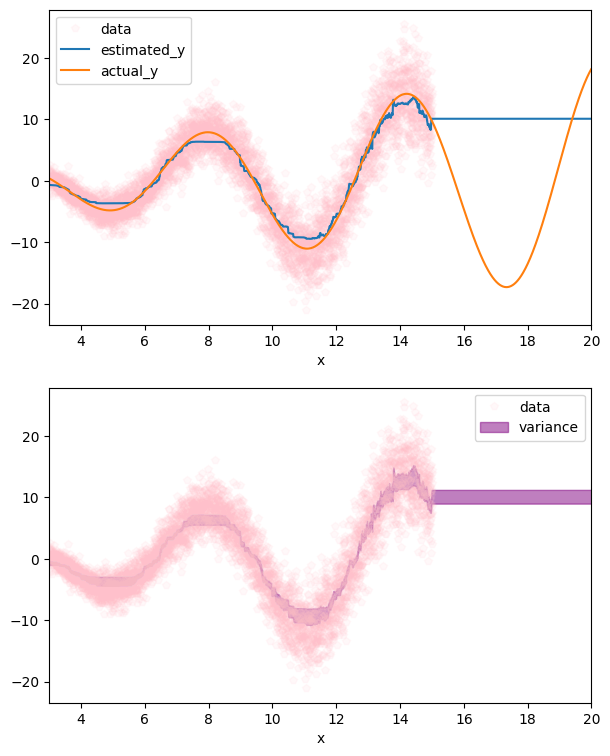

In [60]:

fig = plt.figure(figsize=(7,9))

ax = fig.add_subplot(2,1,1)
ax.plot(X_train,y_train,"p",alpha=0.1,c="pink",label="data")
ax.plot(x_test,y_pred,label="estimated_y")
ax.plot(x_test, y_test, label = "actual_y")
ax.set_xlabel("x")
ax.set_xlim(*xlim)
ax.legend()

ax = fig.add_subplot(2,1,2)
ax.plot(X_train,y_train,"p",alpha=0.1,label="data",c="pink")
# ax.plot(x_test,y_pred,label="estimated_y", c="skyblue")
ax.fill_between(x_test, y_pred - uncertainties, y_pred + uncertainties, alpha = 0.5, label="variance", color="purple")
ax.set_xlabel("x")
ax.set_xlim(*xlim)
ax.legend()
plt.show()